# Yelp User Activity

[Yelp data](https://www.yelp.com/dataset/download).


Yelp rolled out a new interface for a randomly selected group of users. These users were randomly selected among those that posted a review in the month of January 2010. The `id` of these users are listed in the `yelp_academic_dataset_review_treatment.json` file present in the archive.

For this group of users, a new website interface was put in place on February 1st 2010. The goal is to analyze the impact of the new app interface. The company is interested in estimating its effect on user engagement, measured by rating activities. We will focus mainly on the number of ratings for each user. 

In [1]:
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

file_review = os.path.expanduser("yelp/yelp_academic_dataset_review_experiment.json")
file_treatment = os.path.expanduser("yelp/yelp_academic_dataset_review_treatment.json")

def file_len(fname):
    """ Function which efficiently computes the number of lines in file"""
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1



# Loading the yelp review data


In [2]:
def load_data(filepath):
    size = 100000
    review = pd.read_json(filepath, lines=True,
                          dtype={'review_id':str,
                                 'user_id':float,
                                 'business_id':str,
                                 'stars':int,
                                 'date':str,
                                 'text':float,
                                 'useful':int,
                                 'funny':str,
                                 'cool':int},
                          chunksize=size)
    
    chunk_list = []
    for chunk_review in tqdm.tqdm(review, total = np.ceil(file_len(filepath)/size)):
        # Drop columns that aren't needed
        
        chunk_review = chunk_review.drop(["text", "stars", "useful", "funny", "cool"], axis=1)
        chunk_list.append(chunk_review)

    df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
    return df


In [3]:
df_review = load_data(file_review)
df_review['date'] = pd.to_datetime(df_review.date) # convert the date string to an actual date
df_review[['review_id','user_id','date']]

100%|██████████| 80/80.0 [01:53<00:00,  1.41s/it]


,review_id,user_id,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,2017-01-14 21:56:57
...,...,...,...
7998008,LAzw2u1ucY722ryLEXHdgg,6DMFD3BRp-MVzDQelRx5UQ,2019-12-11 01:07:06
7998009,gMDU14Fa_DVIcPvsKtubJA,_g6P8H3-qfbz1FxbffS68g,2019-12-10 04:15:00
7998010,EcY_p50zPIQ2R6rf6-5CjA,Scmyz7MK4TbXXYcaLZxIxQ,2019-06-06 15:01:53
7998011,-z_MM0pAf9RtZbyPlphTlA,lBuAACBEThaQHQGMzAlKpg,2018-07-05 18:45:21


# User engagement over time

In [4]:
def engagement(df):
    count = df[['date', 'user_id']].resample('M', on='date').count()
    plt.plot(count['user_id'])
    plt.yscale('log')
    plt.show()

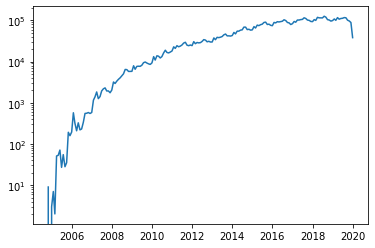

In [5]:
engagement(df_review)

# Effect of the policy over time

We are then going to look at the log number of reviews in each of the months around the introduction of the interface change.


In [6]:
def policy_effect(df_review, file_treatment):
    list_treatment = list(pd.read_json(file_treatment, lines=True)[0])
    df_review['treat'] = False
    for treatment_id in tqdm.tqdm(list_treatment):
        df_review['treat'] = df_review.eval("user_id == '{}' or treat".format(treatment_id))
    df_treated = df_review.loc[df_review['treat']==True]
    count_treated = df_treated.resample('M', on='date').count()
    count = df_review.resample('M', on='date').count()
    plt.plot(count['user_id'], label="untreated")
    plt.plot(count_treated['user_id'], label="treated")
    plt.yscale('log')
    plt.legend()
    plt.show()
    return list_treatment, df_review

100%|██████████| 1500/1500 [09:13<00:00,  2.71it/s]


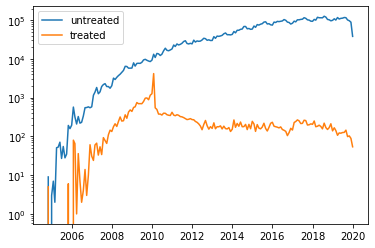

In [25]:
user_treat,df_local = policy_effect(df_review, file_treatment)

While the number of review per month for all users increases, the number of review per month for treatment group seem to have stopped and even breifly declined. Since the two trend increases in parallel before, according to common trend assumption, the two should continue to increase parallely, which they are not.

# Changing comparison group

We clearly created some issues in the way we analyzed our sample. In this section we are going to use a more comparable group, which consist of users from the this group wich are not in the treatment group.

In [26]:
def comparison(df_local, user_treat):
    tmp = df_local.loc[np.datetime64("2010-01-01")<=df_local['date']]
    original_all = np.unique(tmp.loc[tmp['date']<=np.datetime64("2010-01-31")]['user_id'])
    original_control = [e for e in original_all if e not in user_treat]
    df_treated = df_local.loc[df_local['treat']==True]
    df_control = df_local[df_local['user_id'].isin(original_control)]
    count_treated = df_treated.resample('Q', on='date').count()
    count_control = df_control.resample('Q', on='date').count()
    count_treated = count_treated[count_treated['user_id']!=0]
    count_control = count_control[count_control['user_id']!=0]
    plt.plot(count_control['user_id'], label="untreated")
    plt.plot(count_treated['user_id'], label="treated")
    plt.yscale('log')
    plt.legend()
    plt.show()
    avg_control = count_control['user_id']/len(original_control)
    avg_treated = count_treated['user_id']/len(user_treat)
    diff = np.log(avg_treated)-np.log(avg_control)
    plt.plot(diff[10:])
    plt.show()
    return df_local

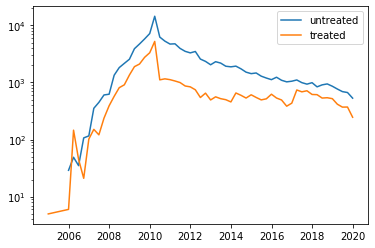

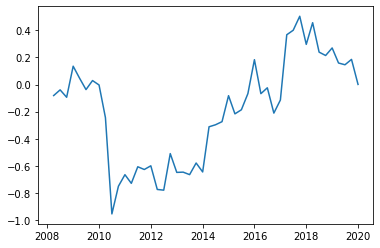

In [27]:
df_local = comparison(df_local,user_treat)

# Using activity per user and time

We are also interested in conducting some inference on our results. However the level of randomization is at the `user` and not at the `review`. Hence we construct observations at the `(user,year)` level. We decide to use years instead of months because the probability at the month level is too low.

In [189]:
import itertools

def activity(df_local, user_treat):
    years = list(range(2004, 2020))
    tmp = df_local.loc[np.datetime64("2010-01-01")<=df_local['date']]
    original_all = np.unique(tmp.query("date <= '2010-02-01'")['user_id'])

    local_user = []
    for u in tqdm.tqdm(original_all):
        treat = u in user_treat
        user_all_post = df_local.query("user_id=='{}'".format(u))
        for y in years:
            year_begin = pd.to_datetime(y, format='%Y')
            year_end = year_begin + np.timedelta64(1, 'Y')
            mask= (user_all_post['date'] > year_begin) & (user_all_post['date'] <= year_end)
            post = 1 if mask.any() else 0
            local_user.append([u, y, treat, post])
    df_local_user = pd.DataFrame(local_user, columns=['user_id','date','treated','post'])
    df_local_user['date'] = pd.to_datetime(df_local_user['date'], format='%Y')

    df_treated = df_local_user.loc[df_local_user['treated']==True]
    df_treated
    df_control = df_local_user.loc[df_local_user['treated']==False]
    count_treated = df_treated.resample('Y', on='date').mean()
    count_control = df_control.resample('Y', on='date').mean()
    count_treated = count_treated[count_treated['post']!=0]
    count_control = count_control[count_control['post']!=0]
    plt.plot(count_control['post'], label="untreated")
    plt.plot(count_treated['post'], label="treated")
    plt.legend()
    plt.show()

    avg_control = count_control['post']
    avg_treated = count_treated['post']
    diff = avg_treated-avg_control
    plt.plot(diff)
    plt.show()

    
    return df_local_user


100%|██████████| 4846/4846 [30:37<00:00,  2.64it/s]


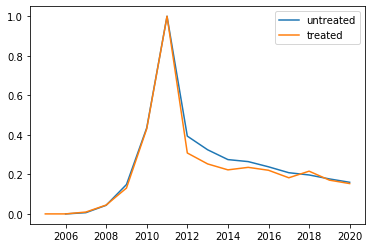

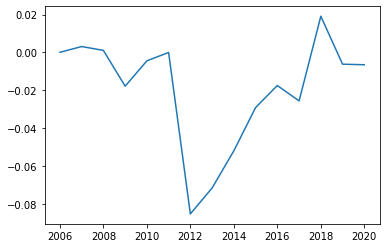

In [221]:
df_local_user = activity(df_local,user_treat)

In [222]:
df_local_user

,user_id,date,treated,post
0,--J8UruLD_xvVuI1lMAxpA,2004-01-01,False,0
1,--J8UruLD_xvVuI1lMAxpA,2005-01-01,False,0
2,--J8UruLD_xvVuI1lMAxpA,2006-01-01,False,0
3,--J8UruLD_xvVuI1lMAxpA,2007-01-01,False,0
4,--J8UruLD_xvVuI1lMAxpA,2008-01-01,False,0
...,...,...,...,...
77531,zznOF_-TAaCRw1lRVQ9GzQ,2015-01-01,False,0
77532,zznOF_-TAaCRw1lRVQ9GzQ,2016-01-01,False,0
77533,zznOF_-TAaCRw1lRVQ9GzQ,2017-01-01,False,0
77534,zznOF_-TAaCRw1lRVQ9GzQ,2018-01-01,False,0


# Constructing confidence intervals


In this final question our goal is to add some inference to our plot. We are going to simply use the asymptotic variance implied by the OLS formula. 

In [223]:
import statsmodels.formula.api as smf


def f(df):
    results = smf.ols('post ~ treated', data=df).fit()
    confs = list(results.conf_int(0.05).iloc[1])
    return pd.DataFrame([[results.params[1], 1/(results.nobs*results.bse[1]), confs[1]-sum(confs)/2]], columns=['beta', 'var', 'conf'])
    
def confidence_interval(df_local_user):
    results = df_local_user.groupby('date').apply(f)
    results = results.reset_index().drop(['level_1'], axis=1)

    plt.errorbar(results['date'], results['beta'], yerr=results['conf'])
    plt.show()

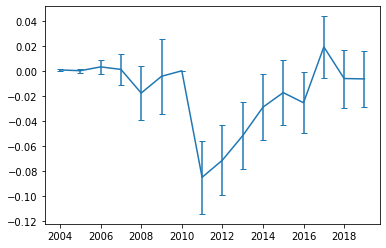

In [224]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 3})
confidence_interval(df_local_user)

Before the start of the experiment, treatment has very little to no effect on posting behavior. After the experiment began, there seems to be a negative correlation between treatment and posting, indicated by a sharp decline after the new interface is implemented. While the effect seems to fade, it may be due to a general decline in average posting amount.